In [1]:
from math import sqrt

def odleglosc(p, q):
    return sqrt((p[0] - q[0])**2 + (p[1] - q[1])**2)

def odleglosc_bez_sqrt(p, q):
    return (p[0] - q[0])**2 + (p[1] - q[1])**2

def odleglosci(punkty):
    n = len(punkty)
    macierz = np.zeros((n,n))
    for k in range(n):
        for j in range(n):
            if(k == j): 
                macierz[k][j] = 0
            if macierz[j][k] != 0:
                macierz[k][j] = macierz[j][k]
            else:
                macierz[k][j] = odleglosc_bez_sqrt(punkty[k], punkty[j])
    return macierz

# moze byc tez zastapione przez:
# from sklearn.metrics.pairwise import euclidean_distances
# euclidean_distances(punkty, punkty)

Mamy zbiór punktów {1, 2, ..., n}. Niech punkt 1 będzie punktem startowym i końcowym szukanego cyklu.
Dla każdego innego punktu k (innego niż 1), znajdujemy ścieżkę o minimalnym koszcie, prowadzącą z 1 do k i zawierającą wszystkie punkty zbioru dokładnie raz.
Niech koszt tej ścieżki wynosi koszt(k), a koszt odpowiedniego cyklu będzie wynosić koszt(k)+dystans(1, k).
Odpowiedzią na problem będzie najkrótszy z (n-1) cykli.

Wykorzystując programowanie dynamiczne, możemy obliczyć koszt(k) za pomocą rozwiązywania podproblemów.

Niech koszt(X, k) będzie oznaczać koszt najkrótszej ścieżki odwiedzającej każdy punkt ze zbioru X dokładnie raz, zaczynając od 1 i kończąc w k. Zaczynamy z podzbiorami mocy 2 i obliczamy koszt(X, k) dla wszystkich X o mocy 2, następnie dla podbiorów o większych mocy. Punkt 1 musi być obecny w każdym podzbiorze.

Jesli siła zbioru X jest równa 2, wówczas X = {1, k}, a koszt(X, k) = dystans(1, i).
Jesli siła zbioru X jest większa niż 2, koszt(X, k) jest najmniejszą wartością spośród wszystkich (koszt(X\\{k}, i) + dystans(k, i)), gdzie i należy do X oraz nie jest równe k ani 1.

Aby przedstawić pozbiory, możemy używać masek bitowych informujących, jakie punkty występują w podbiorze.

Złożoność czasowa rozwiązania wynosi O(n^2 * 2^n).

In [2]:
import numpy as np
import itertools
from math import inf

def czy_w_zbiorze(k, zbior):
    # jesli bit jest w masce, to koniunkcja ze zbiorem będzie różna od 0
    return (1 << k) & zbior != 0

def komiwojazer(punkty):
    macierz = odleglosci(punkty)
    naj_cykl = []
    N = len(punkty)
    K = (1 << N) - 1
    memo = np.full((N, 1 << N), 0)
        
    for k in range(N):
        if k!=0:
            memo[k][(1 << 0) | (1 << k)] = macierz[0][k]

    # podział na podproblemy, tzn. szukanie optymalnej ścieżki dla pozdbiorów zawierających 0
    # dla pozbiorów mocy 2 problem jest trywialny = dystans(0, k)
    powers = [1 << e for e in range(N)]
    for moc in range(3, N+1):
        maski = {sum(bits) for bits in itertools.combinations(powers, moc)}
        podzbiory = (X for X in maski if czy_w_zbiorze(0, X))
        for X in podzbiory:
            for k in range(N):
                if k != 0 and czy_w_zbiorze(k, X):
                    X_bez_k = X ^ (1 << k)
                    rez = inf
                    for i in range(N):
                        if i != 0 and i != k and czy_w_zbiorze(i, X): 
                            rez_ = memo[i][X_bez_k] + macierz[i][k]
                            rez = min(rez, rez_)
                    memo[k][X] = rez

    # odszukujemy i zapisujemy najkrótszy cykl
    ostatni = 0
    naj_cykl.append(0)
    for i in range(1, N):
        punkt = -1
        for j in range(N):
            if j != 0 and czy_w_zbiorze(j, K):
                if punkt == -1: punkt = j
                poprzednia_odl = memo[punkt][K] + macierz[punkt][ostatni]
                nowa_odl = memo[j][K] + macierz[j][ostatni]
                if nowa_odl < poprzednia_odl: punkt = j
        naj_cykl.append(punkt)
        K = K ^ (1 << punkt)
        ostatni = punkt
    naj_cykl.append(0)
    
    return naj_cykl

In [10]:
import matplotlib.pyplot as plt
import time

def wykonaj(punkty):
    start = time.time()
    cykl = komiwojazer(punkty)
    czas = time.time() - start
    if czas > 100:
        czas = czas/60
        print("czas wykonania:\t", czas, "min")
    else:
        print("czas wykonania:\t", czas, "s")
    
    # dlugosc obliczamy już z funkcją sqrt, którą poprzednio pomijaliśmy
    dlugosc = sum([odleglosc(punkty[cykl[i-1]], punkty[cykl[i]]) for i in range(len(cykl))])
    print("długość cyklu:\t", dlugosc)
    print("optymalny cykl:\t", [punkty[i] for i in cykl])

    krawedzie = [(punkty[cykl[i-1]], punkty[cykl[i]]) for i in range(1, len(cykl))]    
    x, y = [x[0] for x in punkty], [x[1] for x in punkty]
    fig = plt.figure(figsize=(8,8))
    plt.gca().set_aspect('equal',adjustable='datalim')
    plt.scatter(x,y)
    for i in krawedzie:
        plt.plot((i[0][0], i[1][0]), (i[0][1], i[1][1]), 'g')    

czas wykonania:	 0.0010018348693847656 s
długość cyklu:	 4.0
optymalny cykl:	 [(0, 1), (1, 1), (1, 0), (0, 0), (0, 1)]


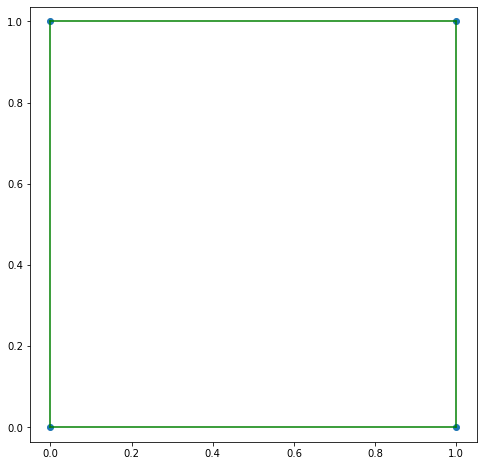

In [19]:
punkty_4 = list(set((i, j) for i in range(2) for j in range(2)))
wykonaj(punkty_4)

czas wykonania:	 0.039971351623535156 s
długość cyklu:	 9.414213562373096
optymalny cykl:	 [(0, 1), (0, 0), (1, 1), (1, 0), (2, 0), (2, 1), (2, 2), (1, 2), (0, 2), (0, 1)]


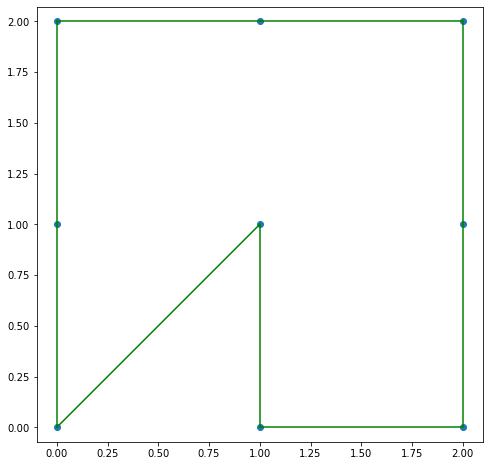

In [12]:
punkty_9 = list(set((i, j) for i in range(3) for j in range(3)))
wykonaj(punkty_9)

czas wykonania:	 5.725362777709961 s
długość cyklu:	 15.414213562373096
optymalny cykl:	 [(0, 1), (0, 0), (1, 1), (1, 0), (2, 0), (2, 1), (2, 2), (1, 2), (1, 3), (2, 3), (2, 4), (1, 4), (0, 4), (0, 3), (0, 2), (0, 1)]


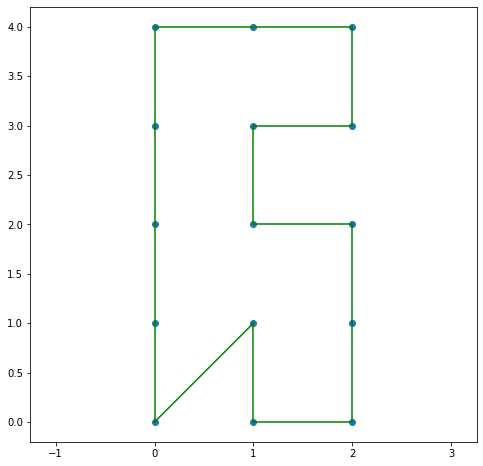

In [13]:
punkty_15 = list(set((i, j) for i in range(3) for j in range(5)))
wykonaj(punkty_15)

czas wykonania:	 13.508602142333984 s
długość cyklu:	 16.0
optymalny cykl:	 [(0, 1), (0, 0), (1, 0), (1, 1), (1, 2), (2, 2), (2, 1), (2, 0), (3, 0), (3, 1), (3, 2), (3, 3), (2, 3), (1, 3), (0, 3), (0, 2), (0, 1)]


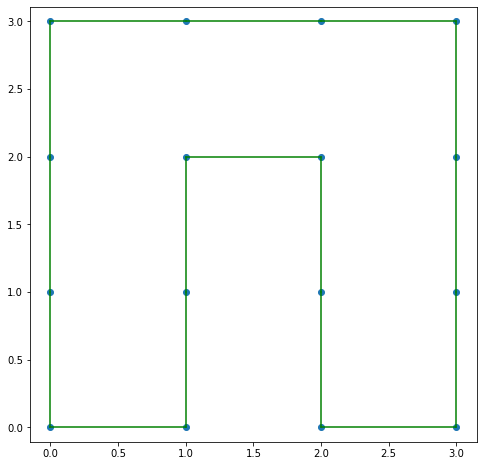

In [14]:
punkty_16 = list(set((i, j) for i in range(4) for j in range(4)))
wykonaj(punkty_16)

czas wykonania:	 68.46336317062378 s
długość cyklu:	 18.0
optymalny cykl:	 [(0, 1), (0, 0), (1, 0), (1, 1), (2, 1), (2, 0), (3, 0), (4, 0), (5, 0), (5, 1), (5, 2), (4, 2), (4, 1), (3, 1), (3, 2), (2, 2), (1, 2), (0, 2), (0, 1)]


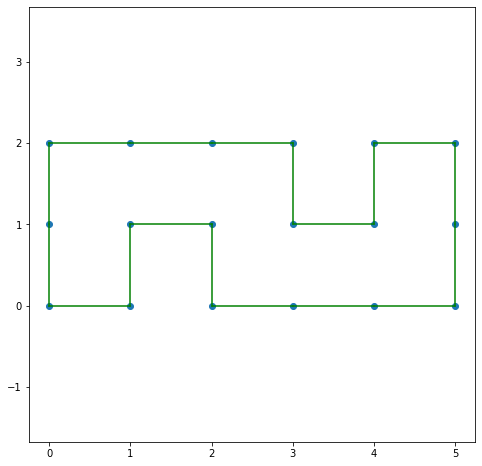

In [17]:
punkty_18 = list(set((i, j) for i in range(6) for j in range(3)))
wykonaj(punkty_18)

czas wykonania:	 5.7950388312339784 min
długość cyklu:	 20.0
optymalny cykl:	 [(3, 4), (3, 3), (3, 2), (3, 1), (3, 0), (2, 0), (1, 0), (0, 0), (0, 1), (0, 2), (1, 2), (1, 1), (2, 1), (2, 2), (2, 3), (1, 3), (0, 3), (0, 4), (1, 4), (2, 4), (3, 4)]


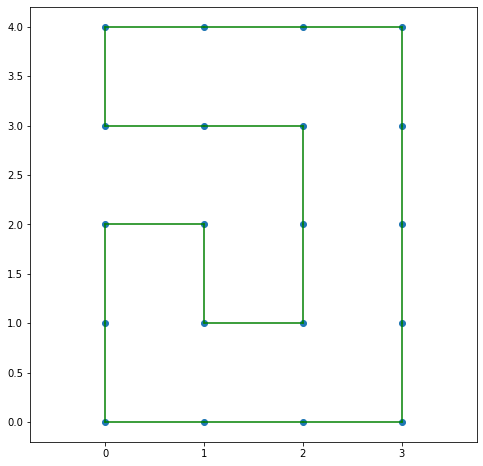

In [15]:
punkty_20 = list(set((i, j) for i in range(4) for j in range(5)))
wykonaj(punkty_20)

czas wykonania:	 12.522484346230824 min
długość cyklu:	 21.414213562373096
optymalny cykl:	 [(0, 2), (1, 3), (1, 2), (1, 1), (0, 1), (0, 0), (1, 0), (2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (1, 6), (0, 6), (0, 5), (1, 5), (1, 4), (0, 4), (0, 3), (0, 2)]


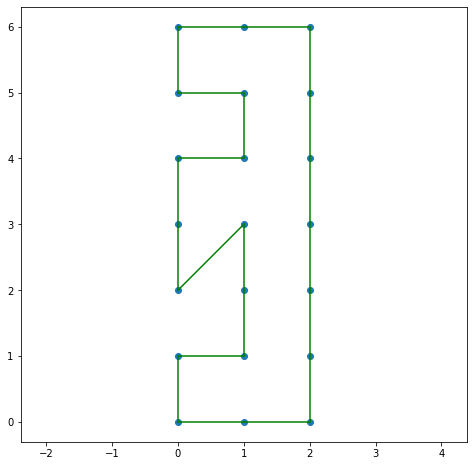

In [16]:
punkty_21 = list(set((i, j) for i in range(3) for j in range(7)))
wykonaj(punkty_21)